In [1]:
import os
os.getcwd()

'C:\\Users\\Gyu\\OneDrive\\unimelb\\2023\\MDS research\\code\\gerber corr'

In [2]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from sklearn.covariance import graphical_lasso

from gerber_utils import *


import matplotlib.pyplot as plt

pd.options.plotting.backend = 'plotly'

today = datetime.datetime.today().strftime('%Y-%m-%d')

pd.options.display.float_format = None

In [3]:
####################################################### params ##################################################################

backtest_name = 'ewma_test'

data_name = 'gerber2021_9assets' # 'gerber2021_9assets', 'snp_55stocks', 'snp_22stocks'

cov_types_to_test = [#'historical',
                     '1-t gerber',
#                      '2-t gerber',
                     'ewma_gerber_1t',
                     # 'ewma_gerber_1t_alt' # alt is the alternative entry-wise version (num and den separately)
                   ] 
resample_period = 'M'

lookback_list = [6, 9, 12, 18, 24]

annual_var_constraint_list = get_annual_var_constraint_list() #[0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4]

phi = 0.1/100

gerber_1t_threshold = 0.5
gerber_2t_thresholds = [0.5, 1]
alpha_2t = 0.5 

lmbda = 0.1 #ewma smoothing/decay parameter

solver = 'ECOS' #'SCS', 'ECOS

####################################################### params ##################################################################

In [4]:
backtest_name_orig = backtest_name
backtest_name = get_backtest_name_params_ewma(backtest_name, resample_period, phi, gerber_1t_threshold, gerber_2t_thresholds, alpha_2t, data_name, lmbda)
backtest_name

'ewma_test_gerber2021_9assets_lmbda0.1_1tT0.5_2tT[0.5, 1]_alpha2T0.5'

# Save configs in /data/backtest_configs.csv

In [5]:
try:
    df_backtest_config = pd.read_csv('./data/backtest_configs_EWMA.csv')
except:
    df_backtest_config = pd.DataFrame()
    
curr_config = pd.DataFrame([backtest_name, data_name, today, cov_types_to_test, resample_period, lmbda, lookback_list, annual_var_constraint_list, phi, gerber_1t_threshold, gerber_2t_thresholds, alpha_2t, solver], index=['backtest_name', 'data_name', 'date', 'cov_types', 'resample_period', 'lambda', 'lookbacks', 'annual_var_constraints', 'phi', 'gerber_1t_threshold', 'gerber_2t_thresholds', 'alpha_2t', 'solver']).T.reset_index(drop=True).astype(str)

# curr_config.to_csv('./data/backtest_configs.csv', index=False)

In [6]:
try:
    df_exists = df_backtest_config.loc[(df_backtest_config['backtest_name'] == curr_config['backtest_name'].values[0]) & (df_backtest_config['date'] == curr_config['date'].values[0]) ]

    if not df_exists.empty:
        df_backtest_config.loc[(df_backtest_config['backtest_name'] == curr_config['backtest_name'].values[0]) & (df_backtest_config['date'] == curr_config['date'].values[0]) ] = curr_config
        
    df_backtest_config = pd.concat([df_backtest_config, curr_config]).reset_index(drop=True).sort_values(by=['backtest_name', 'date'])

except:
    df_backtest_config = curr_config   

df_backtest_config = df_backtest_config.reset_index(drop=True)

In [7]:
# df of all past backtest configs
df_backtest_config.to_csv('./data/backtest_configs_EWMA.csv', index=False)
# df_backtest_config

In [8]:
# current backtest
curr_config

,backtest_name,data_name,date,cov_types,resample_period,lambda,lookbacks,annual_var_constraints,phi,gerber_1t_threshold,gerber_2t_thresholds,alpha_2t,solver
0,ewma_test_gerber2021_9assets_lmbda0.1_1tT0.5_2...,gerber2021_9assets,2023-09-10,"['1-t gerber', 'ewma_gerber_1t']",M,0.1,"[6, 9, 12, 18, 24]","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]",0.001,0.5,"[0.5, 1]",0.5,ECOS


# read prices data

In [9]:
# read data

df = pd.read_parquet(f'./data/assets/{data_name}.parquet')

df.dropna(inplace=True)

In [10]:
df.describe()

,AGG,EFA,EMX,HYG,^FNER,^GSPC,^RUT,^SPGSCI,^XAU
count,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000
mean,95.700133,54.233647,1.491878,64.749935,663.459871,2620.433778,1415.376713,493.039970,103.753568
std,8.579706,9.824199,0.786226,8.550167,111.614313,915.438466,400.594573,127.973873,34.864080
min,82.847542,33.035191,0.350000,48.493855,446.269989,1278.040039,737.419983,228.240005,38.840000
25%,89.039656,47.565574,0.880000,57.941814,586.427505,1953.537537,1136.297546,388.092506,79.930000
50%,94.112938,52.886827,1.230000,65.297016,659.500000,2433.144897,1379.315002,451.479996,93.264999
75%,101.846088,59.589105,2.020000,71.924238,718.742508,3127.342468,1629.277527,627.877502,131.000000
max,112.588852,77.087875,3.710000,80.848740,986.000000,4793.540039,2442.739990,822.299988,202.740005


In [11]:
## resample data

if resample_period != 'd':
    df_resampled = df.resample(resample_period).first() # specify resampling period
else:
    df_resampled = df.copy()

In [12]:
df_returns = df_resampled.pct_change()#['2012-01-31':]  #^FNER only starts from 2012-01-13
df_returns = df_returns.shift(-1)[:-1] #.shift(-1) because you want to match return from today to tomorrow with position (weight) of today
# with [:-1] we get w_t*.T @ return_(t+1) = realized portfolio return

In [13]:
df_returns

,AGG,EFA,EMX,HYG,^FNER,^GSPC,^RUT,^SPGSCI,^XAU
Date,,,,,,,,,
2012-01-31,0.005027,0.056243,0.151899,0.020062,0.064983,0.022069,0.050838,0.008440,0.028957
2012-02-29,-0.000394,0.043807,-0.058608,0.020884,-0.012288,0.037762,0.006867,0.079333,-0.015739
2012-03-31,-0.003600,0.004522,-0.101167,-0.009527,0.044522,0.032713,0.031170,-0.017920,-0.094580
2012-04-30,0.008575,-0.028093,-0.012987,0.010399,0.034222,-0.009316,-0.029430,-0.018261,-0.075900
2012-05-31,0.013673,-0.137484,-0.092105,-0.041347,-0.083296,-0.090894,-0.096177,-0.155059,-0.015907
...,...,...,...,...,...,...,...,...,...
2022-07-31,0.020429,0.050607,0.015625,0.057233,0.065091,0.076673,0.090030,-0.066669,-0.053637
2022-08-31,-0.037963,-0.075065,-0.051282,-0.040855,-0.058226,-0.036852,-0.032119,-0.034048,-0.122893
2022-09-30,-0.029452,-0.061607,0.064865,-0.027359,-0.109035,-0.072708,-0.062513,-0.039441,0.119206


# Portfolio Optimization code

In [23]:
%%time

backtest_path_prefix = f'./data/returns/{backtest_name_orig}/{today}'
create_dir(backtest_path_prefix)

df_returns_iter = df_returns.copy()
df_returns_portfolio_dict = {}
df_weights_all_dict = {}
filename_list = []

nrows = len(lookback_list)
ncols = len(annual_var_constraint_list)


# calc ramp up period for ewma initial data point
ramp_up_1t = find_min_ramp_up(normalize_columns(df_returns_iter), threshold_type='one', threshold=gerber_1t_threshold)
q_dict = {}
print(f'{ramp_up_1t=}, {lmbda=}\n')

print(f'Backtest path: {backtest_path_prefix}\n\n\n')

# go thru each lookback (training) period
for lookback in lookback_list:

    # go thru each target risk (in terms of annualized portfolio variance)
    for annual_var_constraint in annual_var_constraint_list:
        print(f'\nlookback: {lookback}, annual_var_constraint: {annual_var_constraint}\n')
        
        # dict for weights at time t (to hold from t to t+1) for each lookback-variance combination
        df_weights_dict = {cov_type:pd.DataFrame() for cov_type in cov_types_to_test}
        prev_weights_dict = {cov_type:None for cov_type in cov_types_to_test}

        # for ewma initial point
        num_den_prev = calc_num_den_matrix(normalize_columns(df_returns_iter).iloc[:ramp_up_1t],
                                           threshold_type='one',
                                           threshold=gerber_1t_threshold)
        gerber_ewma_1t_prev = num_den_prev['numerator'] / num_den_prev['denominator']
        
        num_ewma_1t_prev = num_den_prev['numerator']
        den_ewma_1t_prev = num_den_prev['denominator']
        
        # go thru each time-step, calc asset weights, rebalancing at resample_period frequency
        for i in range(df_returns_iter.shape[0]):
            if i >= ramp_up_1t + 1:
                df_returns_iter_normalized = normalize_columns(df_returns_iter.iloc[:i,:]) # for ewma that doesn't use lookback
                gerber_tilde_obj = calc_G_tilde(df_returns_iter_normalized, i-1, 'one', threshold=gerber_1t_threshold)
                gerber_tilde = gerber_tilde_obj['corr']
                q = gerber_tilde_obj['q']
                q_dict[i] = q
                gerber_ewma_1t = lmbda * gerber_tilde + (1 - lmbda) * gerber_ewma_1t_prev
                gerber_ewma_cov_1t = np.diag(df_returns_iter[:i].std()).T @  gerber_ewma_1t @ np.diag(df_returns_iter[:i].std())
                gerber_ewma_1t_prev = gerber_ewma_1t.copy()
                
                # non psd-provable ewma version
#                 num_den_t = calc_num_den_matrix(df_returns_iter_normalized.iloc[[i-1]], threshold_type='one', threshold=gerber_1t_threshold)
#                 num_t = (lmbda) * num_den_t['numerator'] + (1-lmbda) * num_ewma_1t_prev
#                 den_t = (lmbda) * num_den_t['denominator'] + (1-lmbda) * den_ewma_1t_prev
#                 gerber_ewma_1_t_alt = num_t / den_t
#                 gerber_ewma_cov_1t_alt = np.diag(df_returns_iter[:i].std()).T @  gerber_ewma_1_t_alt @ np.diag(df_returns_iter[:i].std())
#                 num_ewma_1t_prev = num_t.copy()
#                 den_ewma_1t_prev = den_t.copy()
                
            # skip first 'lookback' number of rows to accumulate data
            if i >= lookback:
                
                timestamp = df_returns_iter.iloc[i,:].name
                print(f'i: {i}, test timestamp: {timestamp}')
                
                # Defining portfolio optimization problem inputs (as known at time t-1)
                df_train = df_returns_iter.iloc[i-lookback:i,:]
                mu = df_train.mean().to_numpy().reshape(1,-1)
                df_train_normalized = normalize_columns(df_train) # standardized returns so we can use common threshold for all assets, just for calculating gerber CORRELATION matrix
        
                ####### construct cov matrices to backtest
                if data_name == "snp_55stocks":
                    historical_corr = df_train.corr().to_numpy()
                    historical_corr = graphical_lasso(historical_corr, alpha=0.5)[0]
                    historical_cov = np.diag(df_train.std()).T @  historical_corr @ np.diag(df_train.std())
                else:
                    historical_cov = df_train.cov().to_numpy()
                
                if '1-t gerber' in cov_types_to_test:
                    gerber_corr = calc_gerber_corr_matrix(df_train_normalized, 
                                            denominator_version=2, 
                                            return_all=True, 
                                            threshold_type='one', 
                                            threshold=gerber_1t_threshold)[0] 
                    if data_name == "snp_55stocks":
                        gerber_corr = graphical_lasso(gerber_corr.to_numpy(), alpha=0.3)[0]
                    gerber_cov = np.diag(df_train.std()).T @  gerber_corr @ np.diag(df_train.std())
                    
                if '2-t gerber' in cov_types_to_test:
                    gerber_corr_2t = calc_gerber_corr_matrix(df_train_normalized, 
                                            denominator_version=2, 
                                            return_all=True, 
                                            threshold_type='two', 
                                            P=gerber_2t_thresholds[0],
                                            Q=gerber_2t_thresholds[1],
                                            alpha=alpha_2t)[0]
                    if data_name == "snp_55stocks":
                        gerber_corr_2t = graphical_lasso(gerber_corr_2t.to_numpy(), alpha=0.3)[0]
                    gerber_cov_2t = np.diag(df_train.std()).T @  gerber_corr_2t @ np.diag(df_train.std())
                
                try:
                    covs = {'1-t gerber':gerber_cov,
                            'ewma_gerber_1t':gerber_ewma_cov_1t,
#                             'ewma_gerber_1t_alt':gerber_ewma_cov_1t_alt,
                           }
                except:
                    covs = {'1-t gerber':gerber_cov,
                            'ewma_gerber_1t':None,
#                             'ewma_gerber_1t_alt':None,

                           }

                # store asset weights for each cov type 
                for cov_type, cov in covs.items():
                    if cov is not None:
                        prob, obj, const, x, daily_vol, daily_var = formulate_problem(mu,
                                                                                      cov,
                                                                                      annual_var_constraint,
                                                                                      resample_period,
                                                                                      prev_weights=prev_weights_dict[cov_type],
                                                                                      phi=phi)
                        try:
                            prob.solve(solver=solver)
                            solved = True
                        except:
                            solved = False
                    
                        # some logic for using prev non nan weights if current weights are nans
                        if solved:
                            weights_temp = pd.DataFrame(x.value, index=df_train.columns, columns=[timestamp]).T
                            if weights_temp.isna().sum().sum() > 0: # nans in weights for time t, i.e. problem with optimization
                                print(f'\tNans in optimized weights for {timestamp}, {cov_type}')
                                # can be None only for the first iteration...
                                weights = pd.DataFrame(prev_weights_dict[cov_type].values, index=[timestamp], columns=df_train.columns) if prev_weights_dict[cov_type] is not None else pd.DataFrame((np.ones(len(df_train.columns))/len(df_train.columns)), index=df_train.columns, columns=[timestamp]).T
                            else:
                                weights = weights_temp
                        else:
                            weights = pd.DataFrame(prev_weights_dict[cov_type].values, index=[timestamp], columns=df_train.columns) if prev_weights_dict[cov_type] is not None else pd.DataFrame((np.ones(len(df_train.columns))/len(df_train.columns)), index=df_train.columns, columns=[timestamp]).T
                        prev_weights_dict[cov_type] = weights
                        df_weights_dict[cov_type] = pd.concat([df_weights_dict[cov_type], weights])
                    else:
                        weights = pd.DataFrame(0, index=df_train.columns, columns=[timestamp]).T
                        
        # save weights for this run
        filename = f'freq{resample_period.upper()}_lookback{lookback}r_var{annual_var_constraint}'
        filename_list.append(filename)
        df_weights_all_dict[filename] = df_weights_dict

        # calc cumulative return %. Discard first 'lookback' # of rows
        df_returns_reduced = df_returns_iter.iloc[lookback:]
        # save total portfolio returns for each timestamp 
        df_returns_portfolio = pd.DataFrame()
        for cov_type in covs.keys():
            df_returns_portf = pd.DataFrame(np.diag(df_weights_dict[cov_type] @ df_returns_reduced.T), columns=[f'{cov_type}_return'], 
                                                index=df_weights_dict[cov_type].index)
            if df_returns_portfolio.empty:
                df_returns_portfolio = pd.concat([df_returns_portfolio, df_returns_portf])
            else:
                df_returns_portfolio = df_returns_portfolio.merge(df_returns_portf, left_index=True, right_index=True)


        # store returns portfolio
        df_returns_portfolio_dict[filename] = df_returns_portfolio

pickle_obj(df_returns_portfolio_dict, f'{backtest_path_prefix}/{backtest_name}_returns.pickle')
pickle_obj(df_weights_all_dict, f'{backtest_path_prefix}/{backtest_name}_weights.pickle')

ramp_up_1t=4, lmbda=0.1

Backtest path: ./data/returns/ewma_1t/2023-09-10




lookback: 6, annual_var_constraint: 0.05



TypeError: 'NoneType' object is not subscriptable

# Plots

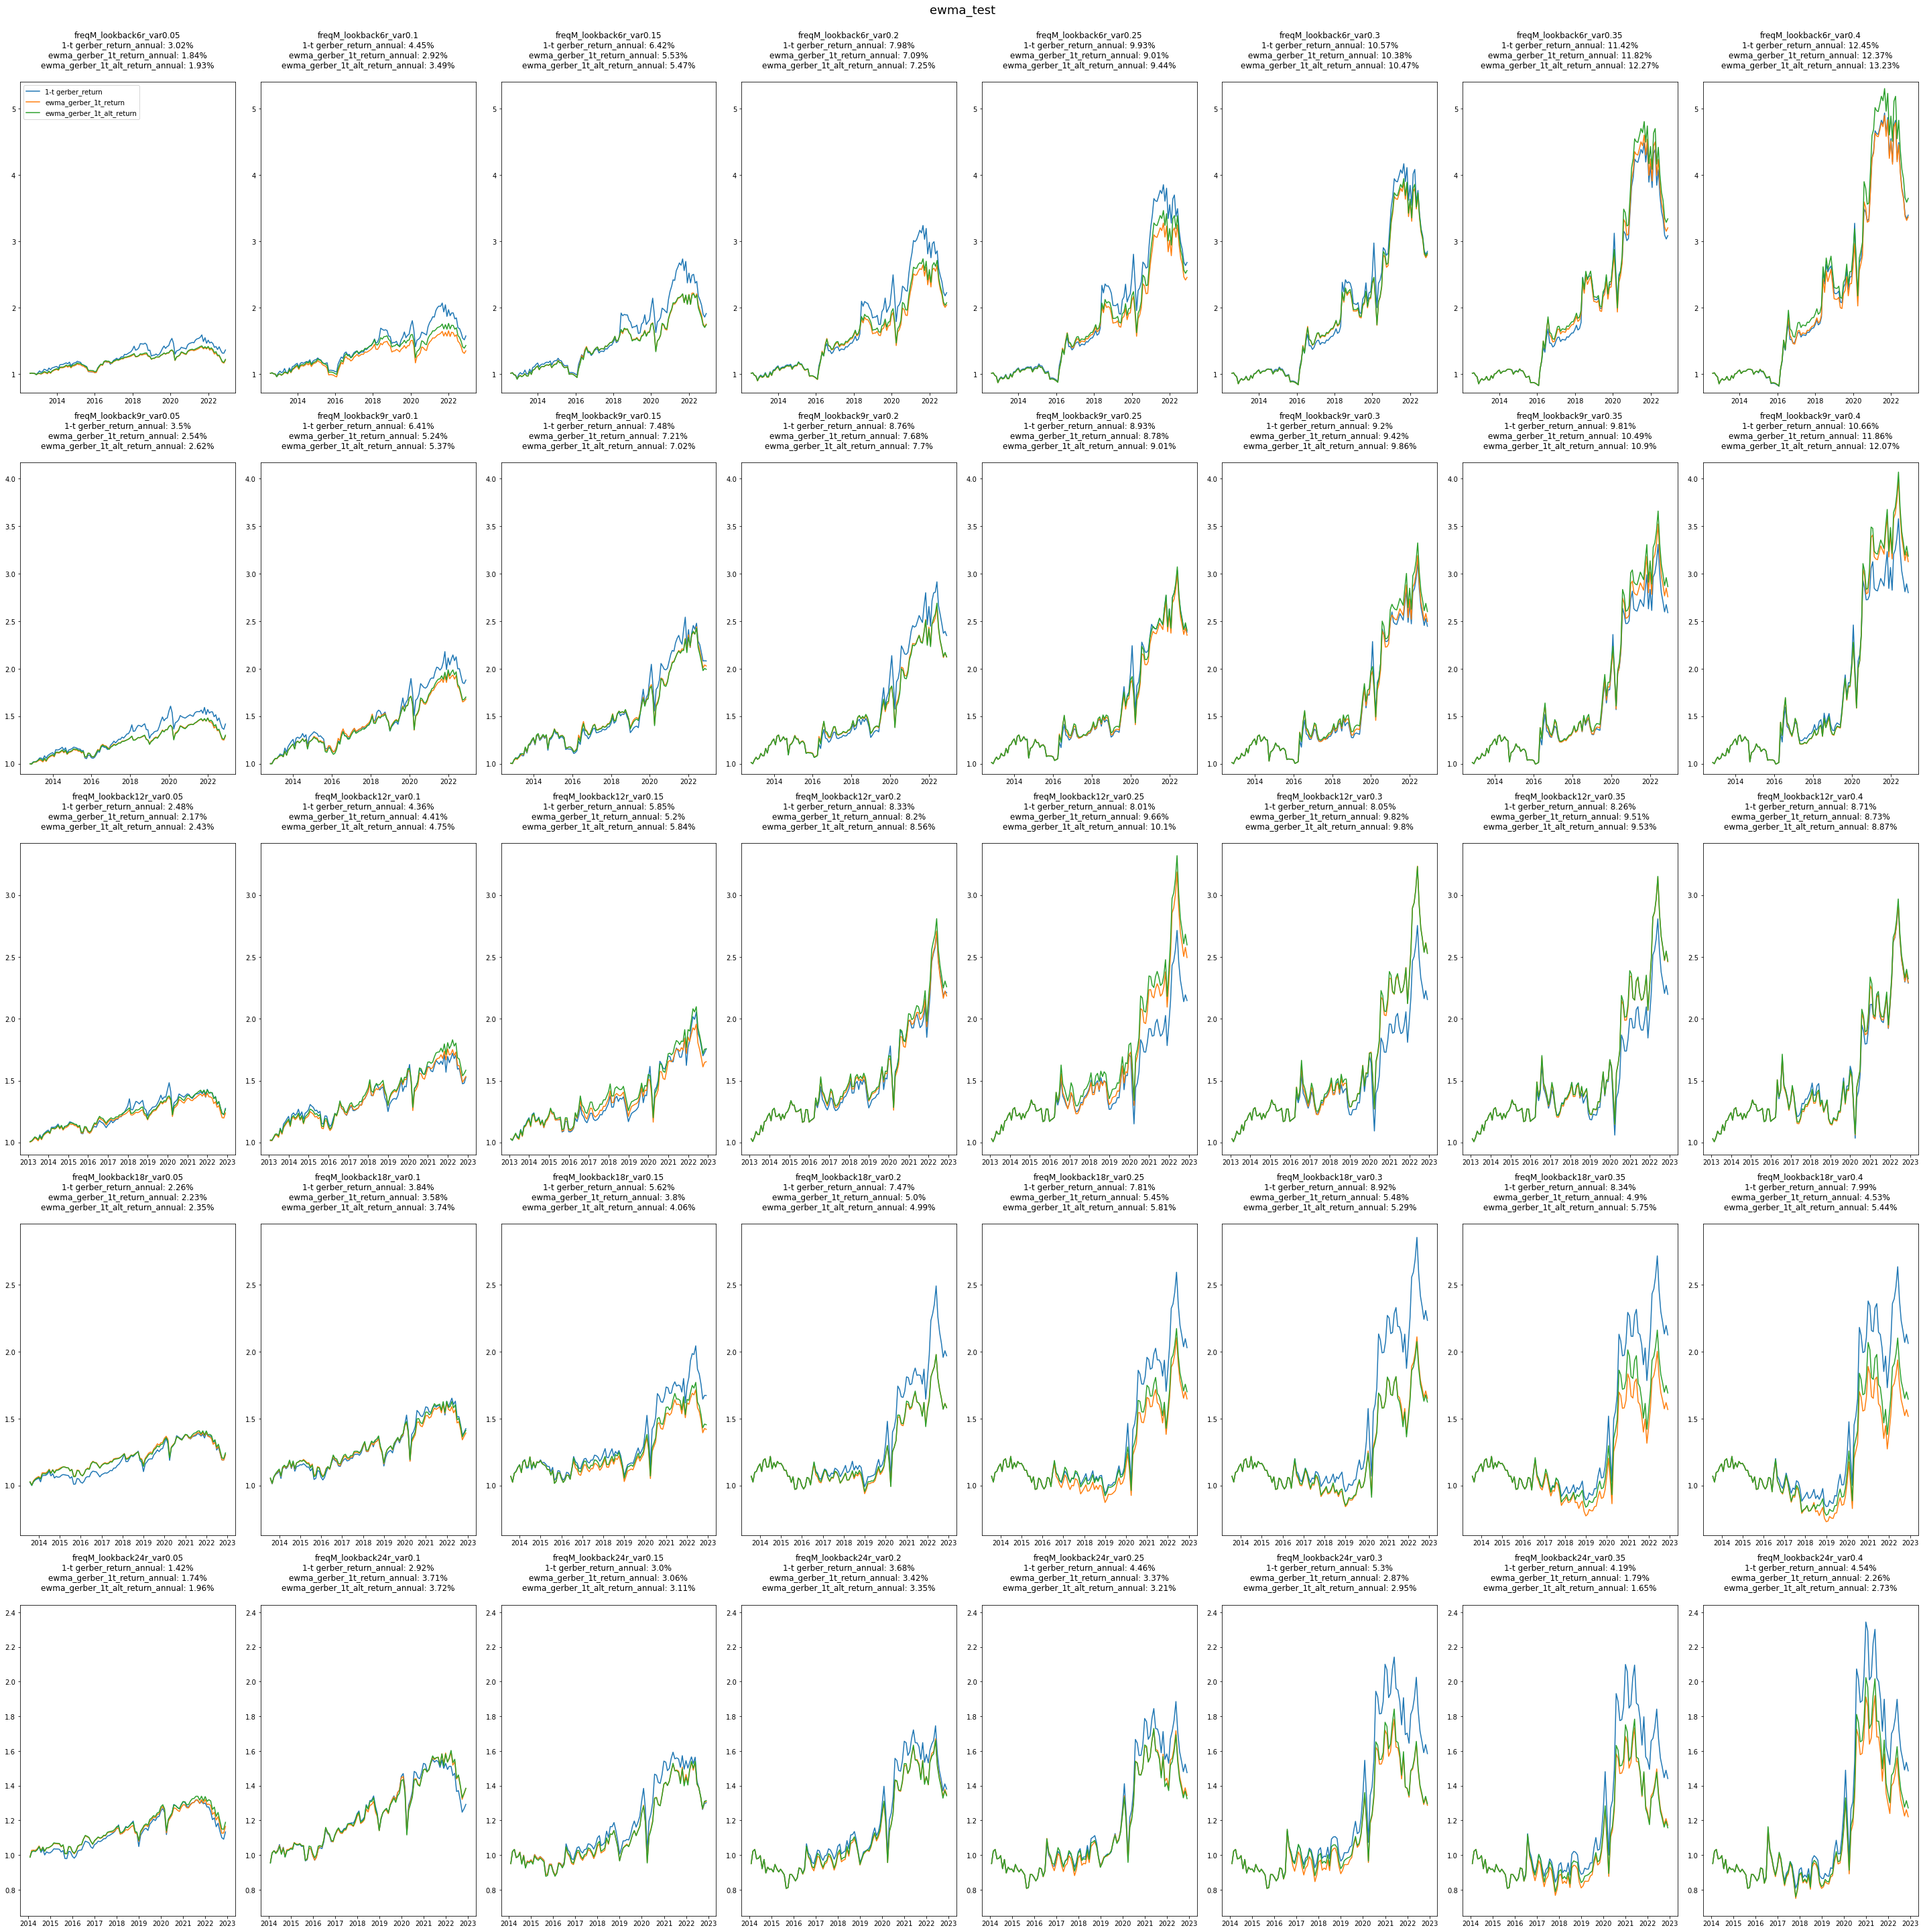

In [254]:
# using standardized returns
plot_cum_returns(df_returns_portfolio_dict, backtest_name, nrows, ncols, resample_period, do_round=4, figsize=(40,40))

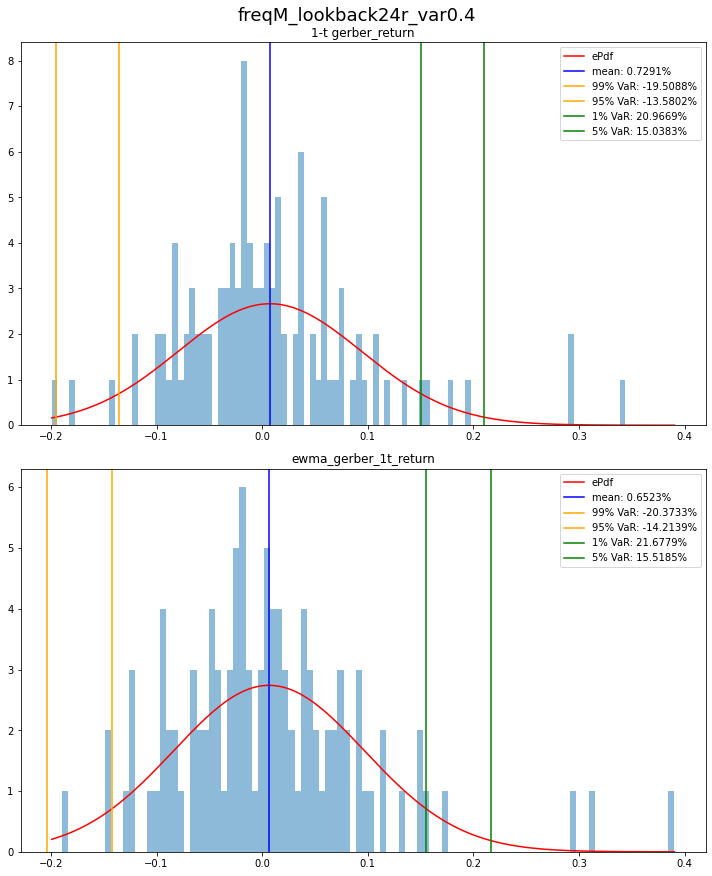

In [156]:
# plotting returns histogram for one specific run as an example

plot_returns_hist(df_returns_portfolio_dict, filename, cov_types_to_test, quantile_values=[0.01,0.05])

# Compute backtest statistics

In [255]:
annual_factor = get_annual_factor(resample_period)

df_stats = {}
for filename in filename_list:
    df_stats[filename] = {}
    
    annual_returns = calc_annual_returns(df_returns_portfolio_dict[filename], resample_period, do_round=5)
    cumm_returns = (df_returns_portfolio_dict[filename]+1).cumprod().iloc[-1].round(5)
    # value_at_risk = calc_value_at_risk(df_returns_portfolio_dict[filename])

    df_stats[filename]['annual_returns'] = {cov:val for cov, val in zip(cov_types_to_test, annual_returns.values)}
    df_stats[filename]['cumm_returns'] = {cov:val for cov, val in zip(cov_types_to_test, cumm_returns.values)}
    df_stats[filename]['sharpe_ratio'] = {cov:val for cov, val in zip(cov_types_to_test, ((np.sqrt(annual_factor)*(df_returns_portfolio_dict[filename].mean()/df_returns_portfolio_dict[filename].std())).values).round(5))}
    df_stats[filename]['99%_VaR'] = {cov:val for cov, val in zip(cov_types_to_test, df_returns_portfolio_dict[filename].apply(lambda x: calc_VaR(x, 0.01), axis=0).values)}
    df_stats[filename]['95%_VaR'] = {cov:val for cov, val in zip(cov_types_to_test, df_returns_portfolio_dict[filename].apply(lambda x: calc_VaR(x, 0.05), axis=0).values)}


df_stats = pd.DataFrame.from_dict(df_stats, orient="index").stack().to_frame()
# to break out the lists into columns
df_stats = pd.DataFrame(df_stats[0].values.tolist(), index=df_stats.index).T

In [256]:
pd.options.display.float_format = '{:.2%}'.format
pd.options.display.max_columns = None

In [257]:
num_metrics = len(df_stats.columns)//ncols//nrows

backtest_stats = {}

for i in range(len(lookback_list)):
    backtest_root = pd.DataFrame([filename.split('_var')[0] for filename in filename_list]).drop_duplicates().values[i][0]
    print(backtest_root)

    df_display = df_stats.iloc[:,i*(ncols*num_metrics):(i+1)*(ncols*num_metrics)]
    backtest_stats[backtest_root] = df_display

    display(backtest_stats[backtest_root])
    print()
    print()

pickle_obj(backtest_stats, f'{backtest_path_prefix}/{backtest_name}_stats.pickle')

freqM_lookback6r


freqM_lookback6r_var0.05                                    \
                             annual_returns cumm_returns sharpe_ratio 99%_VaR   
1-t gerber                            3.02%      136.30%       36.12%  -6.07%   
ewma_gerber_1t                        1.84%      120.92%       30.20%  -4.39%   
ewma_gerber_1t_alt                    1.93%      122.08%       31.09%  -4.47%   

                           freqM_lookback6r_var0.1                            \
                   95%_VaR          annual_returns cumm_returns sharpe_ratio   
1-t gerber          -4.21%                   4.45%      157.41%       38.36%   
ewma_gerber_1t      -3.05%                   2.92%      134.95%       29.76%   
ewma_gerber_1t_alt  -3.11%                   3.49%      143.00%       34.40%   

                                   freqM_lookback6r_var0.15               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber          -8.86%  -6.13%                    6.42%      191.13%   
ewma_gerber_1t      -7.89%  -5.49%                    5.53%      175.18%   
ewma_gerber_1t_alt  -7.81%  -5.42%                    5.47%      174.11%   

                                                freqM_lookback6r_var0.2  \
                   sharpe_ratio 99%_VaR 95%_VaR          annual_returns   
1-t gerber               44.07% -11.12%  -7.67%                   7.98%   
ewma_gerber_1t           42.60%  -9.79%  -6.76%                   7.09%   
ewma_gerber_1t_alt       42.08%  -9.86%  -6.81%                   7.25%   

                                                              \
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR   
1-t gerber              222.52%       46.56% -13.32%  -9.18%   
ewma_gerber_1t          204.05%       45.93% -11.79%  -8.13%   
ewma_gerber_1t_alt      207.34%       46.78% -11.77%  -8.11%   

                   freqM_lookback6r_var0.25                                    \
                             annual_returns cumm_returns sharpe_ratio 99%_VaR   
1-t gerber                            9.93%      268.16%       50.32% -15.34%   
ewma_gerber_1t                        9.01%      245.60%       50.15% -13.74%   
ewma_gerber_1t_alt                    9.44%      255.93%       51.85% -13.76%   

                           freqM_lookback6r_var0.3                            \
                   95%_VaR          annual_returns cumm_returns sharpe_ratio   
1-t gerber         -10.55%                  10.57%      284.82%       50.32%   
ewma_gerber_1t      -9.45%                  10.38%      279.78%       52.06%   
ewma_gerber_1t_alt  -9.45%                  10.47%      282.14%       52.38%   

                                   freqM_lookback6r_var0.35               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber         -16.73% -11.50%                   11.42%      308.47%   
ewma_gerber_1t     -15.41% -10.58%                   11.82%      320.33%   
ewma_gerber_1t_alt -15.40% -10.58%                   12.27%      333.99%   

                                                freqM_lookback6r_var0.4  \
                   sharpe_ratio 99%_VaR 95%_VaR          annual_returns   
1-t gerber               52.05% -17.43% -11.97%                  12.45%   
ewma_gerber_1t           53.92% -17.10% -11.73%                  12.37%   
ewma_gerber_1t_alt       55.19% -17.19% -11.78%                  13.23%   

                                                              
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR  
1-t gerber              339.38%       54.17% -18.11% -12.42%  
ewma_gerber_1t          336.88%       53.68% -18.31% -12.56%  
ewma_gerber_1t_alt      364.76%       55.83% -18.54% -12.70%



freqM_lookback9r


freqM_lookback9r_var0.05                                    \
                             annual_returns cumm_returns sharpe_ratio 99%_VaR   
1-t gerber                            3.50%      141.85%       43.22%  -5.63%   
ewma_gerber_1t                        2.54%      129.03%       40.88%  -4.25%   
ewma_gerber_1t_alt                    2.62%      130.05%       40.84%  -4.40%   

                           freqM_lookback9r_var0.1                            \
                   95%_VaR          annual_returns cumm_returns sharpe_ratio   
1-t gerber          -3.88%                   6.41%      188.11%       54.49%   
ewma_gerber_1t      -2.94%                   5.24%      168.14%       49.52%   
ewma_gerber_1t_alt  -3.04%                   5.37%      170.16%       49.67%   

                                   freqM_lookback9r_var0.15               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber          -8.10%  -5.55%                    7.48%      208.18%   
ewma_gerber_1t      -7.38%  -5.08%                    7.21%      202.90%   
ewma_gerber_1t_alt  -7.54%  -5.19%                    7.02%      199.33%   

                                                freqM_lookback9r_var0.2  \
                   sharpe_ratio 99%_VaR 95%_VaR          annual_returns   
1-t gerber               52.04% -10.33%  -7.10%                   8.76%   
ewma_gerber_1t           54.04%  -9.35%  -6.42%                   7.69%   
ewma_gerber_1t_alt       52.73%  -9.41%  -6.46%                   7.70%   

                                                              \
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR   
1-t gerber              234.88%       54.07% -11.75%  -8.06%   
ewma_gerber_1t          212.28%       49.91% -11.37%  -7.82%   
ewma_gerber_1t_alt      212.53%       49.81% -11.44%  -7.87%   

                   freqM_lookback9r_var0.25                                    \
                             annual_returns cumm_returns sharpe_ratio 99%_VaR   
1-t gerber                            8.93%      238.54%       51.08% -13.24%   
ewma_gerber_1t                        8.78%      235.22%       50.63% -13.08%   
ewma_gerber_1t_alt                    9.01%      240.38%       51.39% -13.18%   

                           freqM_lookback9r_var0.3                            \
                   95%_VaR          annual_returns cumm_returns sharpe_ratio   
1-t gerber          -9.10%                   9.20%      244.65%       49.23%   
ewma_gerber_1t      -8.99%                   9.42%      249.76%       49.83%   
ewma_gerber_1t_alt  -9.05%                   9.86%      260.14%       51.33%   

                                   freqM_lookback9r_var0.35               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber         -14.68% -10.10%                    9.81%      258.92%   
ewma_gerber_1t     -14.70% -10.11%                   10.49%      275.68%   
ewma_gerber_1t_alt -14.77% -10.15%                   10.90%      286.38%   

                                                freqM_lookback9r_var0.4  \
                   sharpe_ratio 99%_VaR 95%_VaR          annual_returns   
1-t gerber               49.70% -15.68% -10.79%                  10.66%   
ewma_gerber_1t           50.96% -16.21% -11.14%                  11.86%   
ewma_gerber_1t_alt       52.18% -16.32% -11.21%                  12.07%   

                                                              
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR  
1-t gerber              280.02%       50.79% -16.78% -11.53%  
ewma_gerber_1t          312.62%       52.70% -17.88% -12.27%  
ewma_gerber_1t_alt      318.46%       53.06% -18.06% -12.39%



freqM_lookback12r


freqM_lookback12r_var0.05                            \
                              annual_returns cumm_returns sharpe_ratio   
1-t gerber                             2.48%      127.55%       32.33%   
ewma_gerber_1t                         2.17%      123.74%       35.06%   
ewma_gerber_1t_alt                     2.43%      126.86%       37.96%   

                                   freqM_lookback12r_var0.1               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber          -5.65%  -3.93%                    4.36%      152.66%   
ewma_gerber_1t      -4.35%  -3.01%                    4.41%      153.38%   
ewma_gerber_1t_alt  -4.44%  -3.07%                    4.75%      158.42%   

                                                freqM_lookback12r_var0.15  \
                   sharpe_ratio 99%_VaR 95%_VaR            annual_returns   
1-t gerber               39.31%  -8.29%  -5.74%                     5.85%   
ewma_gerber_1t           42.58%  -7.47%  -5.16%                     5.20%   
ewma_gerber_1t_alt       44.91%  -7.54%  -5.20%                     5.84%   

                                                              \
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR   
1-t gerber              175.73%       43.52% -10.15%  -7.01%   
ewma_gerber_1t          165.31%       41.42%  -9.48%  -6.55%   
ewma_gerber_1t_alt      175.60%       45.13%  -9.55%  -6.58%   

                   freqM_lookback12r_var0.2                                    \
                             annual_returns cumm_returns sharpe_ratio 99%_VaR   
1-t gerber                            8.33%      221.09%       51.87% -11.80%   
ewma_gerber_1t                        8.20%      218.43%       52.96% -11.18%   
ewma_gerber_1t_alt                    8.56%      225.88%       54.15% -11.37%   

                           freqM_lookback12r_var0.25               \
                   95%_VaR            annual_returns cumm_returns   
1-t gerber          -8.10%                     8.01%      214.76%   
ewma_gerber_1t      -7.67%                     9.66%      249.47%   
ewma_gerber_1t_alt  -7.80%                    10.10%      259.75%   

                                                freqM_lookback12r_var0.3  \
                   sharpe_ratio 99%_VaR 95%_VaR           annual_returns   
1-t gerber               46.99% -13.30%  -9.16%                    8.05%   
ewma_gerber_1t           54.90% -12.82%  -8.79%                    9.82%   
ewma_gerber_1t_alt       55.95% -13.14%  -9.00%                    9.80%   

                                                              \
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR   
1-t gerber              215.55%       45.32% -14.32%  -9.87%   
ewma_gerber_1t          253.12%       52.15% -14.25%  -9.79%   
ewma_gerber_1t_alt      252.80%       51.39% -14.59% -10.03%   

                   freqM_lookback12r_var0.35                            \
                              annual_returns cumm_returns sharpe_ratio   
1-t gerber                             8.26%      219.74%       44.87%   
ewma_gerber_1t                         9.51%      246.09%       47.64%   
ewma_gerber_1t_alt                     9.53%      246.64%       47.52%   

                                   freqM_lookback12r_var0.4               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber         -15.13% -10.44%                    8.71%      228.81%   
ewma_gerber_1t     -16.11% -11.09%                    8.73%      229.41%   
ewma_gerber_1t_alt -16.26% -11.20%                    8.87%      232.33%   

                                                 
                   sharpe_ratio 99%_VaR 95%_VaR  
1-t gerber               45.01% -16.16% -11.14%  
ewma_gerber_1t           43.81% -17.08% -11.79%  
ewma_gerber_1t_alt       43.98% -17.34% -11.96%



freqM_lookback18r


freqM_lookback18r_var0.05                            \
                              annual_returns cumm_returns sharpe_ratio   
1-t gerber                             2.26%      123.39%       31.19%   
ewma_gerber_1t                         2.23%      123.07%       34.48%   
ewma_gerber_1t_alt                     2.35%      124.47%       35.33%   

                                   freqM_lookback18r_var0.1               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber          -5.31%  -3.69%                    3.84%      142.59%   
ewma_gerber_1t      -4.57%  -3.17%                    3.58%      139.32%   
ewma_gerber_1t_alt  -4.70%  -3.26%                    3.74%      141.36%   

                                                freqM_lookback18r_var0.15  \
                   sharpe_ratio 99%_VaR 95%_VaR            annual_returns   
1-t gerber               34.99%  -8.51%  -5.91%                     5.62%   
ewma_gerber_1t           35.62%  -7.60%  -5.27%                     3.80%   
ewma_gerber_1t_alt       36.38%  -7.77%  -5.38%                     4.06%   

                                                              \
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR   
1-t gerber              167.36%       40.41% -10.86%  -7.51%   
ewma_gerber_1t          142.06%       31.94%  -9.85%  -6.84%   
ewma_gerber_1t_alt      145.51%       33.15% -10.08%  -7.00%   

                   freqM_lookback18r_var0.2                                    \
                             annual_returns cumm_returns sharpe_ratio 99%_VaR   
1-t gerber                            7.47%      197.05%       44.50% -13.22%   
ewma_gerber_1t                        5.00%      158.38%       35.45% -11.80%   
ewma_gerber_1t_alt                    4.99%      158.20%       35.02% -12.06%   

                           freqM_lookback18r_var0.25               \
                   95%_VaR            annual_returns cumm_returns   
1-t gerber          -9.12%                     7.81%      203.09%   
ewma_gerber_1t      -8.19%                     5.45%      164.77%   
ewma_gerber_1t_alt  -8.37%                     5.81%      170.16%   

                                                freqM_lookback18r_var0.3  \
                   sharpe_ratio 99%_VaR 95%_VaR           annual_returns   
1-t gerber               42.96% -14.96% -10.33%                    8.92%   
ewma_gerber_1t           34.94% -13.77%  -9.55%                    5.48%   
ewma_gerber_1t_alt       36.34% -13.90%  -9.63%                    5.29%   

                                                              \
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR   
1-t gerber              223.49%       44.92% -16.39% -11.31%   
ewma_gerber_1t          165.29%       33.57% -15.27% -10.60%   
ewma_gerber_1t_alt      162.49%       32.60% -15.61% -10.85%   

                   freqM_lookback18r_var0.35                            \
                              annual_returns cumm_returns sharpe_ratio   
1-t gerber                             8.34%      212.65%       42.07%   
ewma_gerber_1t                         4.90%      156.85%       30.28%   
ewma_gerber_1t_alt                     5.75%      169.24%       33.24%   

                                   freqM_lookback18r_var0.4               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber         -17.22% -11.90%                    7.99%      206.31%   
ewma_gerber_1t     -17.06% -11.87%                    4.53%      151.76%   
ewma_gerber_1t_alt -17.16% -11.92%                    5.44%      164.61%   

                                                 
                   sharpe_ratio 99%_VaR 95%_VaR  
1-t gerber               40.02% -18.27% -12.63%  
ewma_gerber_1t           28.74% -18.28% -12.72%  
ewma_gerber_1t_alt       31.75% -18.35% -12.75%



freqM_lookback24r


freqM_lookback24r_var0.05                            \
                              annual_returns cumm_returns sharpe_ratio   
1-t gerber                             1.42%      113.38%       21.31%   
ewma_gerber_1t                         1.74%      116.60%       27.15%   
ewma_gerber_1t_alt                     1.96%      118.91%       29.68%   

                                   freqM_lookback24r_var0.1               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber          -5.33%  -3.73%                    2.92%      129.26%   
ewma_gerber_1t      -4.75%  -3.31%                    3.71%      138.33%   
ewma_gerber_1t_alt  -4.83%  -3.36%                    3.72%      138.54%   

                                                freqM_lookback24r_var0.15  \
                   sharpe_ratio 99%_VaR 95%_VaR            annual_returns   
1-t gerber               28.49%  -8.53%  -5.94%                     3.00%   
ewma_gerber_1t           34.75%  -8.28%  -5.74%                     3.06%   
ewma_gerber_1t_alt       34.45%  -8.44%  -5.85%                     3.11%   

                                                              \
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR   
1-t gerber              130.19%       26.46% -10.41%  -7.25%   
ewma_gerber_1t          130.87%       27.06% -10.21%  -7.12%   
ewma_gerber_1t_alt      131.43%       27.15% -10.40%  -7.25%   

                   freqM_lookback24r_var0.2                                    \
                             annual_returns cumm_returns sharpe_ratio 99%_VaR   
1-t gerber                            3.68%      138.06%       28.47% -12.19%   
ewma_gerber_1t                        3.42%      134.94%       27.32% -11.96%   
ewma_gerber_1t_alt                    3.36%      134.21%       26.89% -12.13%   

                           freqM_lookback24r_var0.25               \
                   95%_VaR            annual_returns cumm_returns   
1-t gerber          -8.49%                     4.46%      147.54%   
ewma_gerber_1t      -8.34%                     3.37%      134.35%   
ewma_gerber_1t_alt  -8.45%                     3.21%      132.52%   

                                                freqM_lookback24r_var0.3  \
                   sharpe_ratio 99%_VaR 95%_VaR           annual_returns   
1-t gerber               30.79% -13.80%  -9.59%                    5.30%   
ewma_gerber_1t           25.91% -13.83%  -9.64%                    2.87%   
ewma_gerber_1t_alt       25.20% -13.89%  -9.69%                    2.95%   

                                                              \
                   cumm_returns sharpe_ratio 99%_VaR 95%_VaR   
1-t gerber              158.49%       32.70% -15.86% -11.01%   
ewma_gerber_1t          128.70%       23.31% -15.75% -11.00%   
ewma_gerber_1t_alt      129.57%       23.61% -15.81% -11.04%   

                   freqM_lookback24r_var0.35                            \
                              annual_returns cumm_returns sharpe_ratio   
1-t gerber                             4.19%      144.14%       27.99%   
ewma_gerber_1t                         1.79%      117.15%       19.35%   
ewma_gerber_1t_alt                     1.65%      115.72%       18.90%   

                                   freqM_lookback24r_var0.4               \
                   99%_VaR 95%_VaR           annual_returns cumm_returns   
1-t gerber         -17.55% -12.22%                    4.54%      148.55%   
ewma_gerber_1t     -17.18% -12.02%                    2.26%      122.09%   
ewma_gerber_1t_alt -17.40% -12.18%                    2.73%      127.18%   

                                                 
                   sharpe_ratio 99%_VaR 95%_VaR  
1-t gerber               28.89% -19.51% -13.58%  
ewma_gerber_1t           21.56% -19.25% -13.45%  
ewma_gerber_1t_alt       23.10% -19.42% -13.56%

(could create some bar plot functions for each metric for above table)

# Efficient frontiers

In [14]:
for i in range(len(lookback_list)):
    backtest_root = pd.DataFrame([filename.split('_var')[0] for filename in filename_list]).drop_duplicates().values[i][0]

    annual_ret_cols = [col for col in backtest_stats[backtest_root].columns if 'annual_returns' in col]
    df_frontier_plot = backtest_stats[backtest_root][annual_ret_cols]
    df_frontier_plot.columns = get_annual_var_constraint_list()

    plot_frontier(df_frontier_plot, backtest_root, value_vars=['1-t gerber', 'ewma_gerber_1t'])#, 'ewma_gerber_1t_alt' ])

NameError: name 'filename_list' is not defined